In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

from keras.applications.vgg19 import VGG19,preprocess_input


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/NSCLC_SMALL/TRAIN/'
TEST_DIR = '/content/drive/MyDrive/NSCLC_SMALL/TEST/'
VAL_DIR = '/content/drive/MyDrive/NSCLC_SMALL/VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

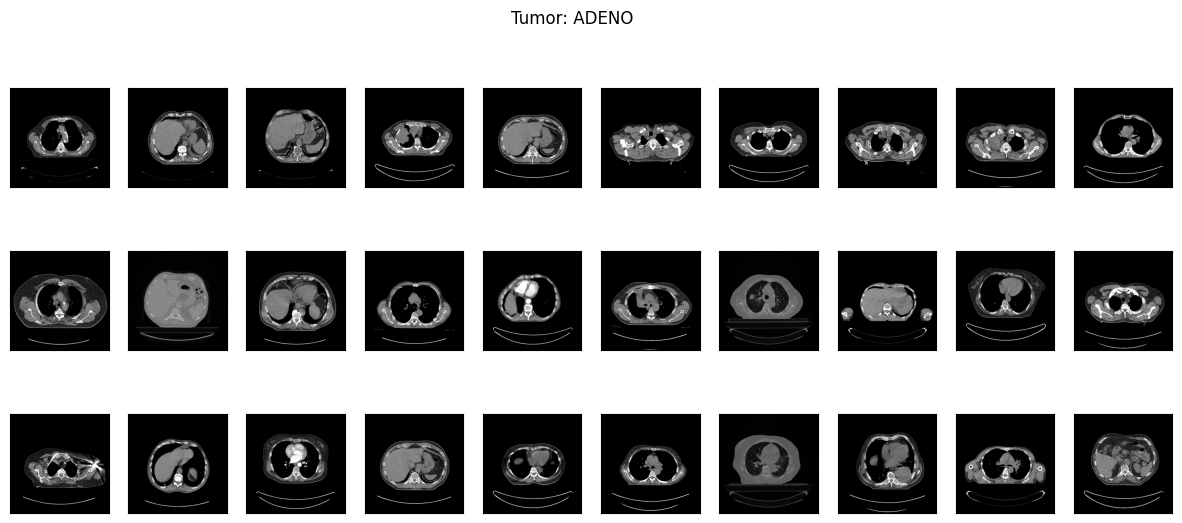

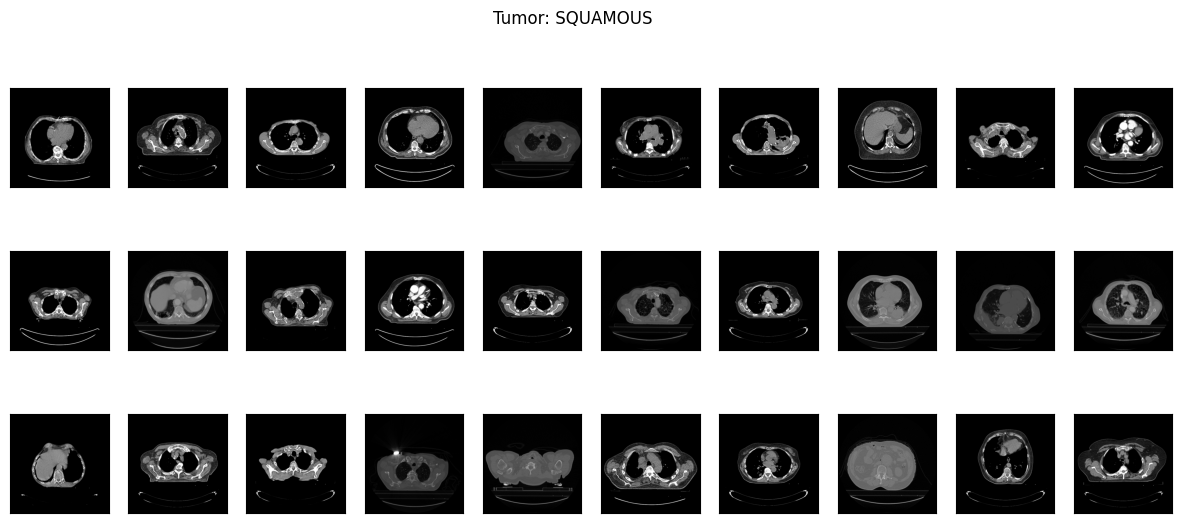

In [ ]:
plot_samples(X_train, y_train, labels, 30)

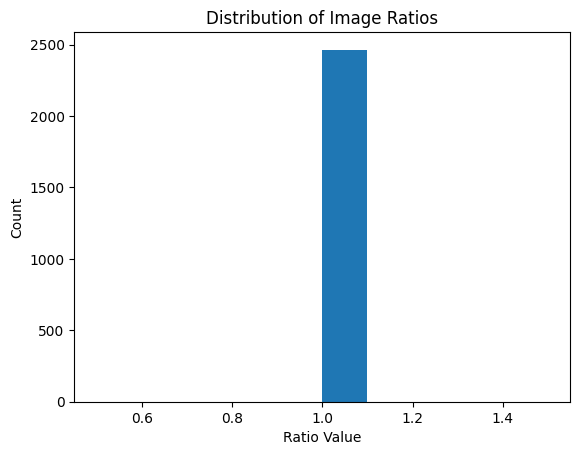

In [ ]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
img = cv2.imread('/content/drive/MyDrive/NSCLC_SMALL/TEST/ADENO/1-033.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

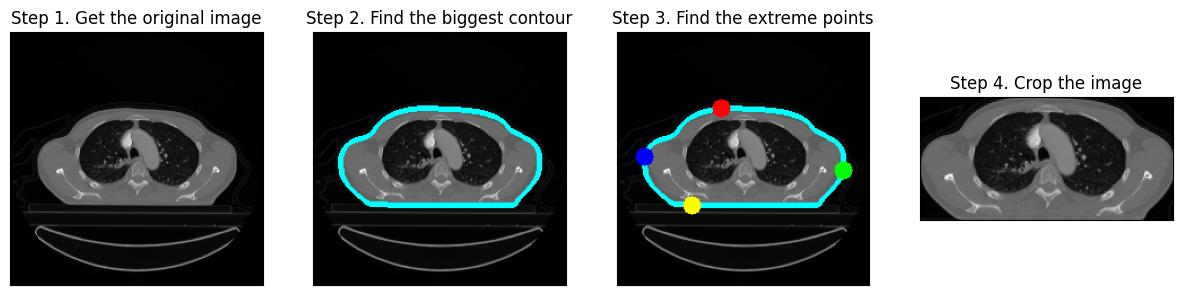

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

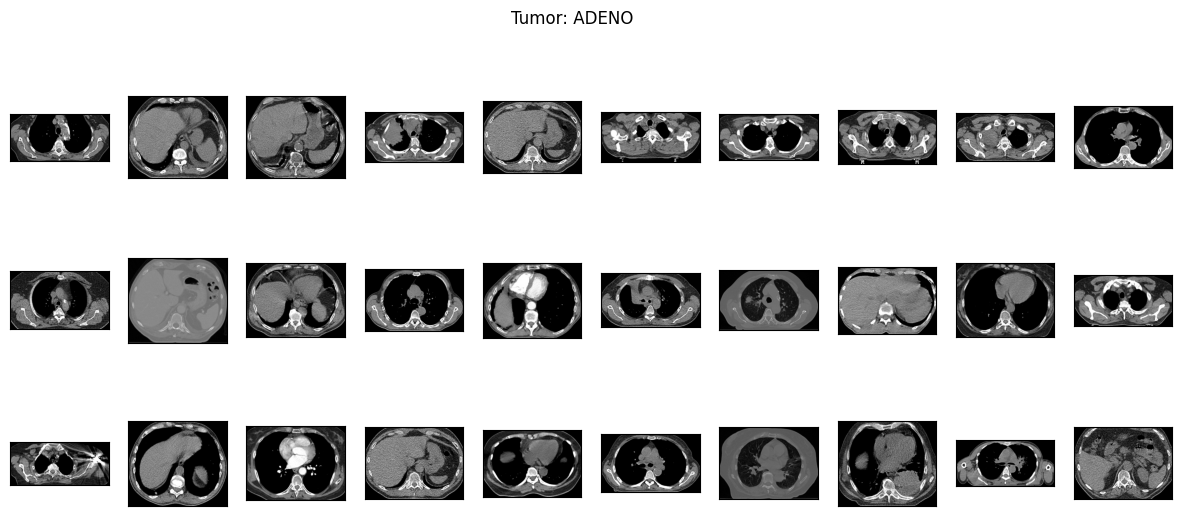

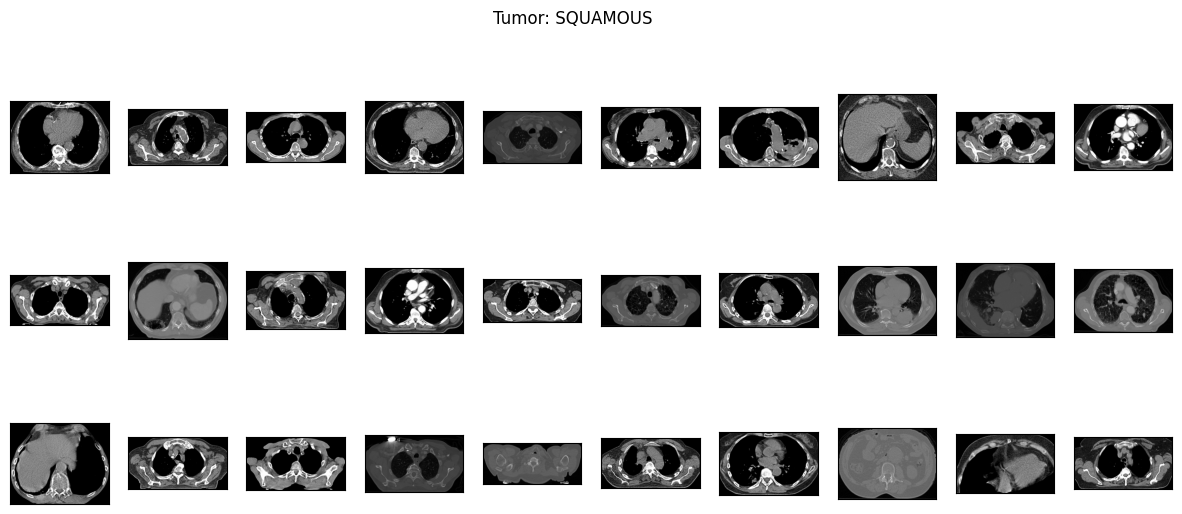

In [ ]:
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'AD/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'SQ/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/SQ TRAIN_CROP/AD TEST_CROP/SQ TEST_CROP/AD VAL_CROP/SQ VAL_CROP/AD

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

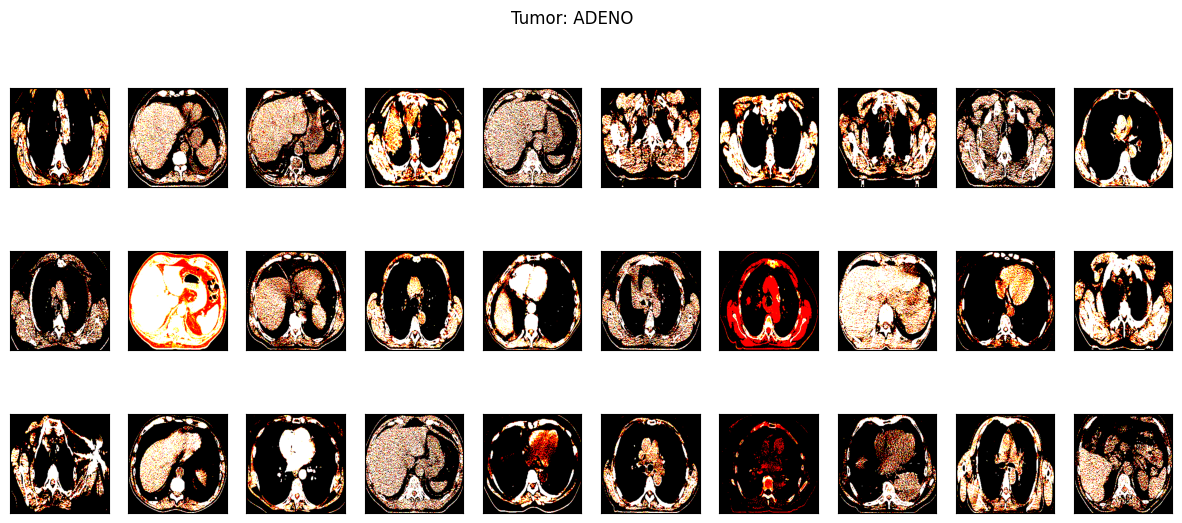

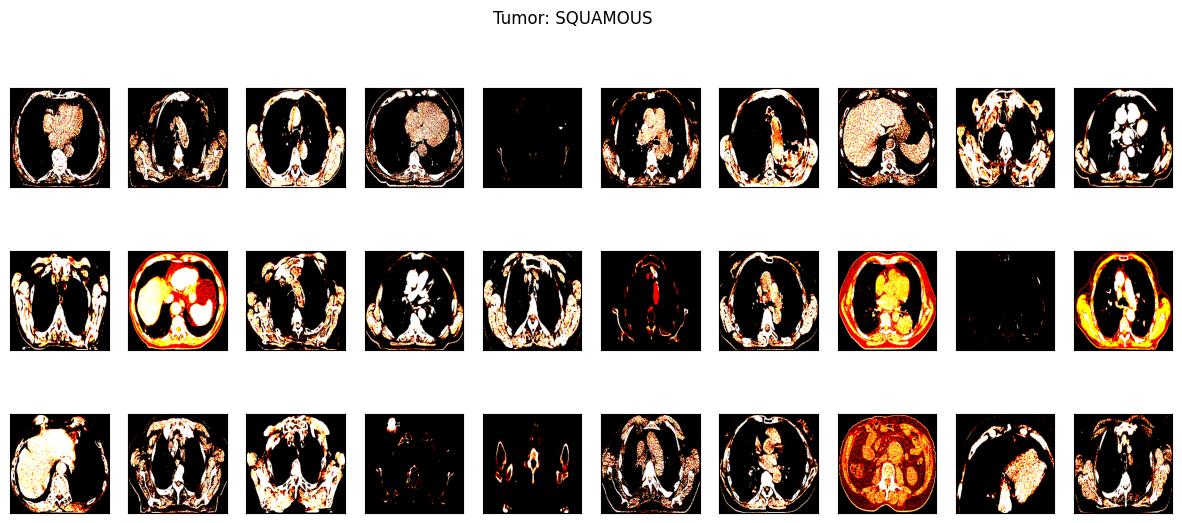

In [ ]:
plot_samples(X_train_prep, y_train, labels, 30)

In [ ]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
os.mkdir('preview')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

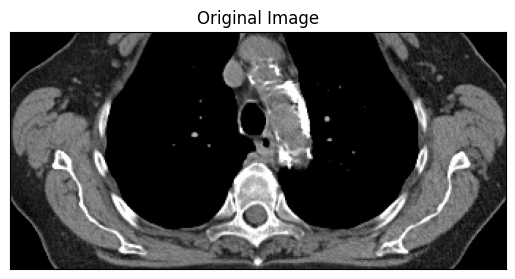

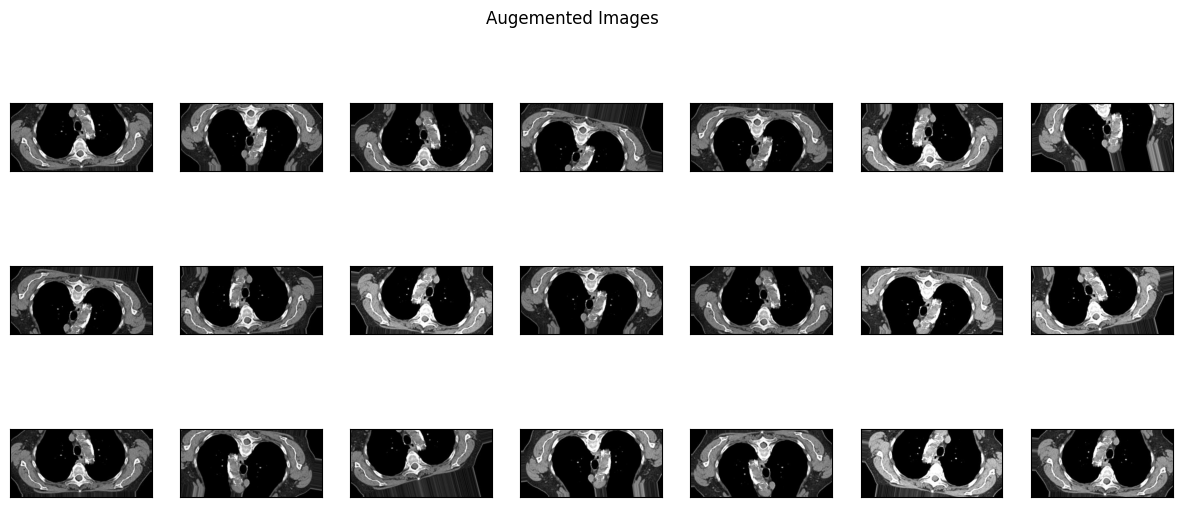

In [ ]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
!rm -rf preview/

In [ ]:
import tensorflow as tf

TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
TEST_DIR='TEST_CROP/'

img_width, img_height = 224, 224

# Create data generators for feature extraction
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode=None,  # We don't need labels, only images
    shuffle=False  # Important: Keep the order of images to match with labels later
)

validation_generator = datagen.flow_from_directory(
    VAL_DIR,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode=None,
    shuffle=False
)


Found 2000 images belonging to 2 classes.
Found 264 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
# Load the pre-trained VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Extract features for training, validation, and test sets
train_features = base_model.predict(train_generator)
validation_features = base_model.predict(validation_generator)
test_features = base_model.predict(test_generator)


1/7 [===>..........................] - ETA: 2:18

In [ ]:
# Flatten the extracted feature tensor s
train_features = np.reshape(train_features, (train_features.shape[0], -1))
validation_features = np.reshape(validation_features, (validation_features.shape[0], -1))
test_features = np.reshape(test_features, (test_features.shape[0], -1))


In [ ]:
# Prepare labels for training and validation sets
train_labels = np.array([0] * (train_features.shape[0] // 2) + [1] * (train_features.shape[0] // 2))
validation_labels = np.array([0] * (validation_features.shape[0] // 2) + [1] * (validation_features.shape[0] // 2))
test_labels= np.array([0] * (test_features.shape[0] // 2) + [1] * (test_features.shape[0] // 2))

In [ ]:
# Visualize the model architecture and save it to a file
!pip install visualkeras
import visualkeras

visualkeras.layered_view(base_model, legend=True)

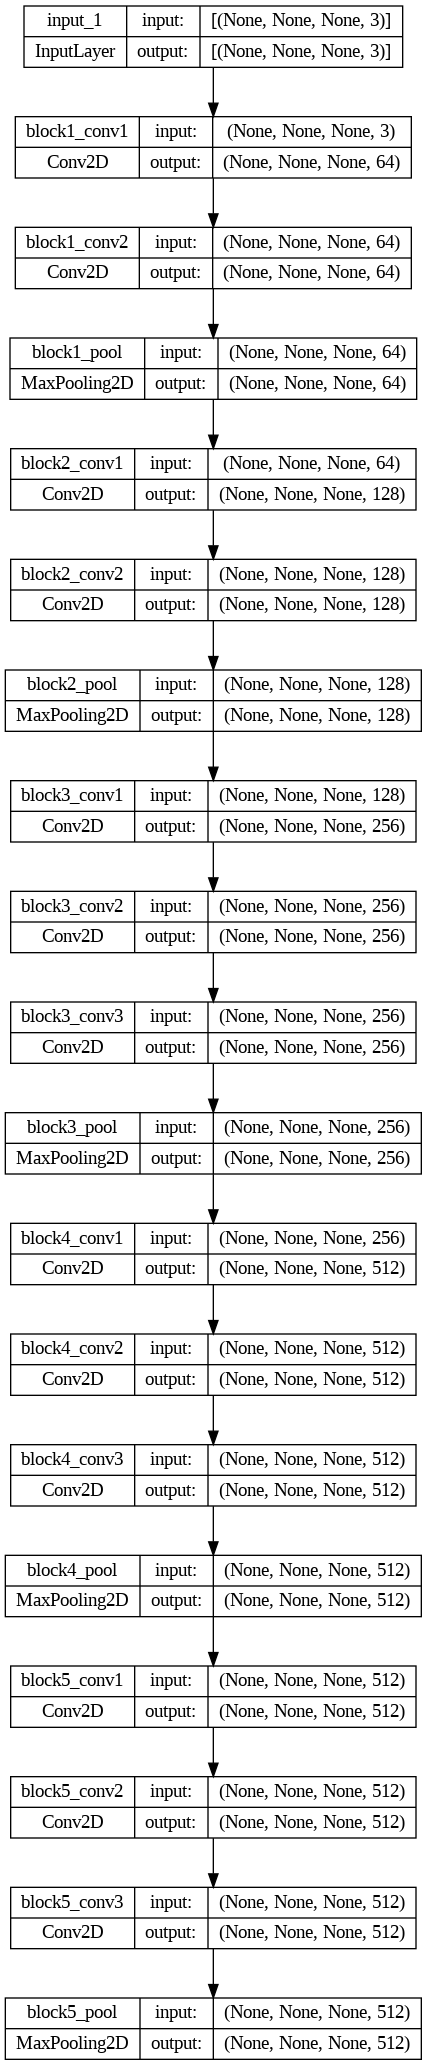

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(base_model, to_file='vgg16_model.png', show_shapes=True, show_layer_names=True)

In [ ]:

import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Assuming you have already loaded and preprocessed your data:
# train_features, train_labels, test_features, test_labels

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Create an SVM classifier
svm_classifier = svm.SVC()

# Create a StandardScaler for feature scaling (optional but recommended)
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)


# Create GridSearchCV object
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')

# Perform the grid search to find the best hyperparameters
grid_search.fit(train_features_scaled, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Train the SVM classifier with the best hyperparameters
best_svm_classifier = svm.SVC(C=best_params['C'], kernel=best_params['kernel'])
best_svm_classifier.fit(train_features_scaled, train_labels)


# Evaluate the optimized SVM classifier on the test set
test_predictions = best_svm_classifier.predict(test_features_scaled)
accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy with Optimized SVM: {accuracy*100:.2f}%')


KeyboardInterrupt: ignored

Best Hyperparameters: {'C': 0.1, 'kernel': 'linear'}


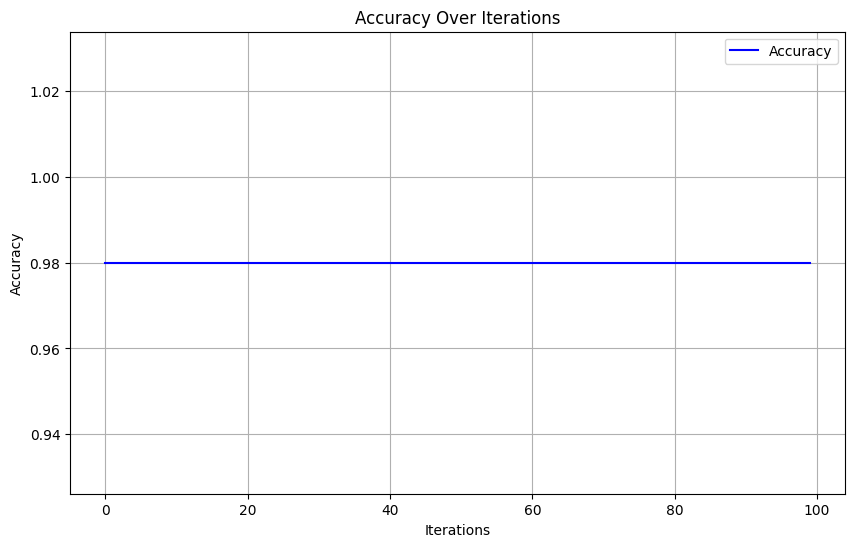

In [ ]:
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming you have already loaded and preprocessed your data:
# train_features, train_labels, test_features, test_labels

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Create an SVM classifier
svm_classifier = svm.SVC()

# Create a StandardScaler for feature scaling (optional but recommended)
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Create GridSearchCV object
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')

# Perform the grid search to find the best hyperparameters
grid_search.fit(train_features_scaled, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Train the SVM classifier with the best hyperparameters
best_svm_classifier = svm.SVC(C=best_params['C'], kernel=best_params['kernel'])
best_svm_classifier.fit(train_features_scaled, train_labels)

# Initialize lists to store loss and accuracy values
loss_history = []
accuracy_history = []

# Evaluate the model over multiple iterations (you can modify this loop)
for _ in range(100):  # Adjust the number of iterations as needed
    test_predictions = best_svm_classifier.predict(test_features_scaled)

    # Calculate and record accuracy
    accuracy = accuracy_score(test_labels, test_predictions)
    accuracy_history.append(accuracy)

    # Calculate and record the loss (if you have a custom loss function)
    # loss = your_loss_function(test_labels, test_predictions)
    # loss_history.append(loss)

# Visualize accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracy_history)), accuracy_history, label='Accuracy', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Iterations')
plt.grid(True)
plt.show()

# Uncomment and adapt the code for visualizing loss if you have a custom loss function
# plt.figure(figsize=(10, 6))
# plt.plot(range(len(loss_history)), loss_history, label='Loss', color='red')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss Over Iterations')
# plt.grid(True)
# plt.show()


<Axes: title={'center': 'Support Vector Machine Confusion Matrix'}>

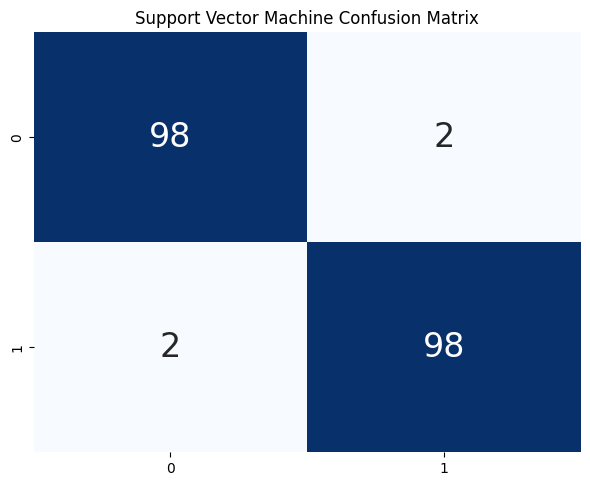

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_svm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(24,12))
plt.subplot(2,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(test_labels, test_predictions)
print(f'F1 Score: {f1:.2f}')


F1 Score: 0.98


In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(test_labels, test_predictions)
print(f'Precision: {precision:.2f}')


Precision: 0.98


In [ ]:
from sklearn.metrics import recall_score

recall = recall_score(test_labels, test_predictions)
print(f'Recall: {recall:.2f}')


Recall: 0.98


In [ ]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer  # Example for text data

# Assuming you have already loaded and preprocessed your data:
# train_data, train_labels, test_data, test_labels (for text data, for instance)

# Create a CountVectorizer for text data (replace with your data preprocessing)
vectorizer = CountVectorizer()

# Define the hyperparameter grid to search
param_grid = {
    'alpha': [0.1, 1.0, 10.0],  # Smoothing parameter
    # Add more hyperparameters as needed
}

# Create a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Create GridSearchCV object
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')

# Perform the grid search to find the best hyperparameters
grid_search.fit(train_features, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Train the Multinomial Naive Bayes classifier with the best hyperparameters
best_nb_classifier = MultinomialNB(alpha=best_params['alpha'])
best_nb_classifier.fit(train_features, train_labels)

# Evaluate the optimized Multinomial Naive Bayes classifier on the test set
test_predictions = best_nb_classifier.predict(test_features)
accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy with Optimized Naive Bayes: {accuracy*100:.2f}%')


In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Assuming you have already loaded and preprocessed your data:
# train_features, train_labels, test_features, test_labels

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]    # Minimum number of samples required to be at a leaf node
}

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Create GridSearchCV object
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')

# Perform the grid search to find the best hyperparameters
grid_search.fit(train_features, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Train the Decision Tree classifier with the best hyperparameters
best_dt_classifier = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf']
)
best_dt_classifier.fit(train_features, train_labels)

# Evaluate the optimized Decision Tree classifier on the test set
test_predictions = best_dt_classifier.predict(test_features)
accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy with Optimized Decision Tree: {accuracy*100:.2f}%')


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Assuming you have already loaded and preprocessed your data:
# train_features, train_labels, test_features, test_labels

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],       # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],      # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]        # Minimum number of samples required to be at a leaf node
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Create GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# Perform the grid search to find the best hyperparameters
grid_search.fit(train_features, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Train the Random Forest classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf']
)
best_rf_classifier.fit(train_features, train_labels)

# Evaluate the optimized Random Forest classifier on the test set
test_predictions = best_rf_classifier.predict(test_features)
accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy with Optimized Random Forest: {accuracy*100:.2f}%')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Assuming you have loaded and preprocessed your data, and you have train_features, train_labels, test_features, test_labels

# Initialize lists to store model names, loss, and accuracy values
models = ['VGG', 'VGG+SVM', 'VGG+Naive Bayes', 'VGG+Decision Tree', 'VGG+Random Forest']

accuracy_values = [51,98 , 73, 78.5, 91]



# Create a DataFrame to store the results
data = {'Model': models, 'Accuracy': accuracy_values}
df = pd.DataFrame(data)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create a second y-axis for accuracy
ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(models, accuracy_values, marker='o', color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Accuracy Comparison for Different Models')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()
